# Line RT: 3D homogeneous,
# spherically symmetric, all constant

## 0) Setup

In [1]:
# Define Magritte folders

MagritteSetupFolder = '/home/frederik/Dropbox/Astro/Magritte/modules/setup/'
ProjectFolder       = '/home/frederik/MagritteProjects/Lines_3D_LTE/'

In [2]:
# Import tools and libraries

import numpy as np

from bokeh.plotting import figure, show, gridplot
from bokeh.palettes import cividis
from bokeh.io       import output_notebook
output_notebook()

from glob import glob
from sys  import path
path.insert(0, MagritteSetupFolder)

# Import from MagritteSetupFolder
from spheres  import deSphere, sphereVar, nRays, nSides
from lineData import LineData, planck, relativeDifference
from setup    import setupMagritte
from model    import model, mapToXD

Loading BokehJS ...

## 1) Define model

Assume a 1D model (i.e. 1 ray) with constant temperature, density and abundances and a linear velocity field, yielding a constant velocity gradient

\begin{align}
T(r)     \ &= \ cte, \\
\rho(r)  \ &= \ cte, \\
n_{i}(r) \ &= \ cte, \\
v(r)     \ &= \ cte,
\end{align}

where $L$ is the total length of the model and $v_{\max}$ is the maximum speed reached in the model. (Numerical values given below.) We write it in this way to ensure that velocities in the model are always much smaller than $c$, since our equations for Doppler shift are not valid otherwise.

There is CMB radiation incoming on both ends of the ray as boundary condition.

In [3]:
# Define model

model = model (dim=1)

model.ncells = 15

dens = 1.0E+12   # [m^-3]
abun = 1.0E+4    # [m^-3]
temp = 1.0E+02   # [K]
dx   = 1.0E5     # [m]
dT   = 1.0E1     # [K]
dv   = 0.0E0     # [m/s]

model.density     = [dens     for _ in range(model.ncells)]
model.abundance   = [abun     for _ in range(model.ncells)]
model.temperature = [temp     for _ in range(model.ncells)]

model.x = [dx*i for i in range(model.ncells-1)]
model.x = model.x + [1000.0*model.x[-1]]
model.y = [0.0  for _ in range(model.ncells)]
model.z = [0.0  for _ in range(model.ncells)]

model.vx = [0.0 for _ in range(model.ncells)]
model.vy = [0.0 for _ in range(model.ncells)]
model.vz = [0.0 for _ in range(model.ncells)]

model.boundary = [0, model.ncells-1]

# Define nsidesList for mapping to 3D model
nsidesList = [int((2+i)/3)  for i in range(model.ncells-1)]
nsidesList = nsidesList + [3]
nraysList  = [nRays(nsides) for nsides in nsidesList]

# Map 1D model to spherically symmetric 3D model
(model3D, cellsInShell) = mapToXD(model, dimension=3, nraysList=nraysList)

# Define rays
model3D.defineRays (nrays=nRays(3))

# Write new model data
model3D.writeInput (ProjectFolder + 'Magritte_files/')

# Run setup
setupMagritte (projectFolder = ProjectFolder, runName = '')

print(f'ncells in 3D model = {model3D.ncells}')
print(f'nrays  in 3D model = {model3D.nrays} ')

ncells in 3D model = 1489
nrays  in 3D model = 108 


In [4]:
# Plot model

plot_model_1 = figure (plot_width=400, plot_height=250, y_axis_type='log')
plot_model_1.line (model.x, model.density)
plot_model_1.xaxis.axis_label = "x [m]"
plot_model_1.yaxis.axis_label = "density [m^-3]"

plot_model_2 = figure (plot_width=400, plot_height=250, y_axis_type='log')
plot_model_2.line (model.x, model.abundance)
plot_model_2.xaxis.axis_label = "x [m]"
plot_model_2.yaxis.axis_label = "abundance [xm^-3]"

plot_model_3 = figure(plot_width=400, plot_height=250)
plot_model_3.line (model.x, model.temperature)
plot_model_3.xaxis.axis_label = "x [m]"
plot_model_3.yaxis.axis_label = "temperature [K]"

plot_model_4 = figure(plot_width=400, plot_height=250)
plot_model_4.line (model.x, model.vx)
plot_model_4.xaxis.axis_label = "x [m]"
plot_model_4.yaxis.axis_label = "velocity_x [m^-3]"

plot_model = gridplot ([[plot_model_1, plot_model_2],[plot_model_3, plot_model_4]])

show (plot_model)

## 2) Get Magritte output

In [6]:
# Get Magritte data

ioFolders = glob(ProjectFolder + 'io/*/')
ioFolders.sort()

inputFolders  = [folder +  'input/' for folder in ioFolders]
outputFolders = [folder + 'output/' for folder in ioFolders]

lastOutput = outputFolders[-1]
lastInput  =  inputFolders[-1]

pops_files = glob(lastOutput + 'populations_0*.txt')
Jeff_files = glob(lastOutput + 'Jeff_0*.txt')
J_files    = glob(lastOutput + 'J_*.txt')
G_files    = glob(lastOutput + 'G_*.txt')
nu_files   = glob(lastOutput + 'frequencies_nu*.txt')
lnr_files  = glob(lastOutput + 'frequencies_line_nr*.txt')
eta_files  = glob(lastOutput + 'eta_0*.txt')
chi_files  = glob(lastOutput + 'chi_0*.txt')

pops_files.sort()
Jeff_files.sort()
eta_files.sort()
chi_files.sort()

pops_3D_data = [np.loadtxt(fileName) for fileName in pops_files]
Jeff_3D_data = [np.loadtxt(fileName) for fileName in Jeff_files]
J_3D_data    = [np.loadtxt(fileName) for fileName in J_files]
G_3D_data    = [np.loadtxt(fileName) for fileName in G_files]
nu_3D_data   = [np.loadtxt(fileName) for fileName in nu_files]
lnr_3D_data  = [np.loadtxt(fileName) for fileName in lnr_files]
eta_3D_data  = [np.loadtxt(fileName) for fileName in eta_files]
chi_3D_data  = [np.loadtxt(fileName) for fileName in chi_files]

# Import linedata
lineData = LineData (ProjectFolder + '/Magritte_files/linedata/hco+.dat')

### 2.1) Images

/home/frederik/software/anaconda3/envs/magritte/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


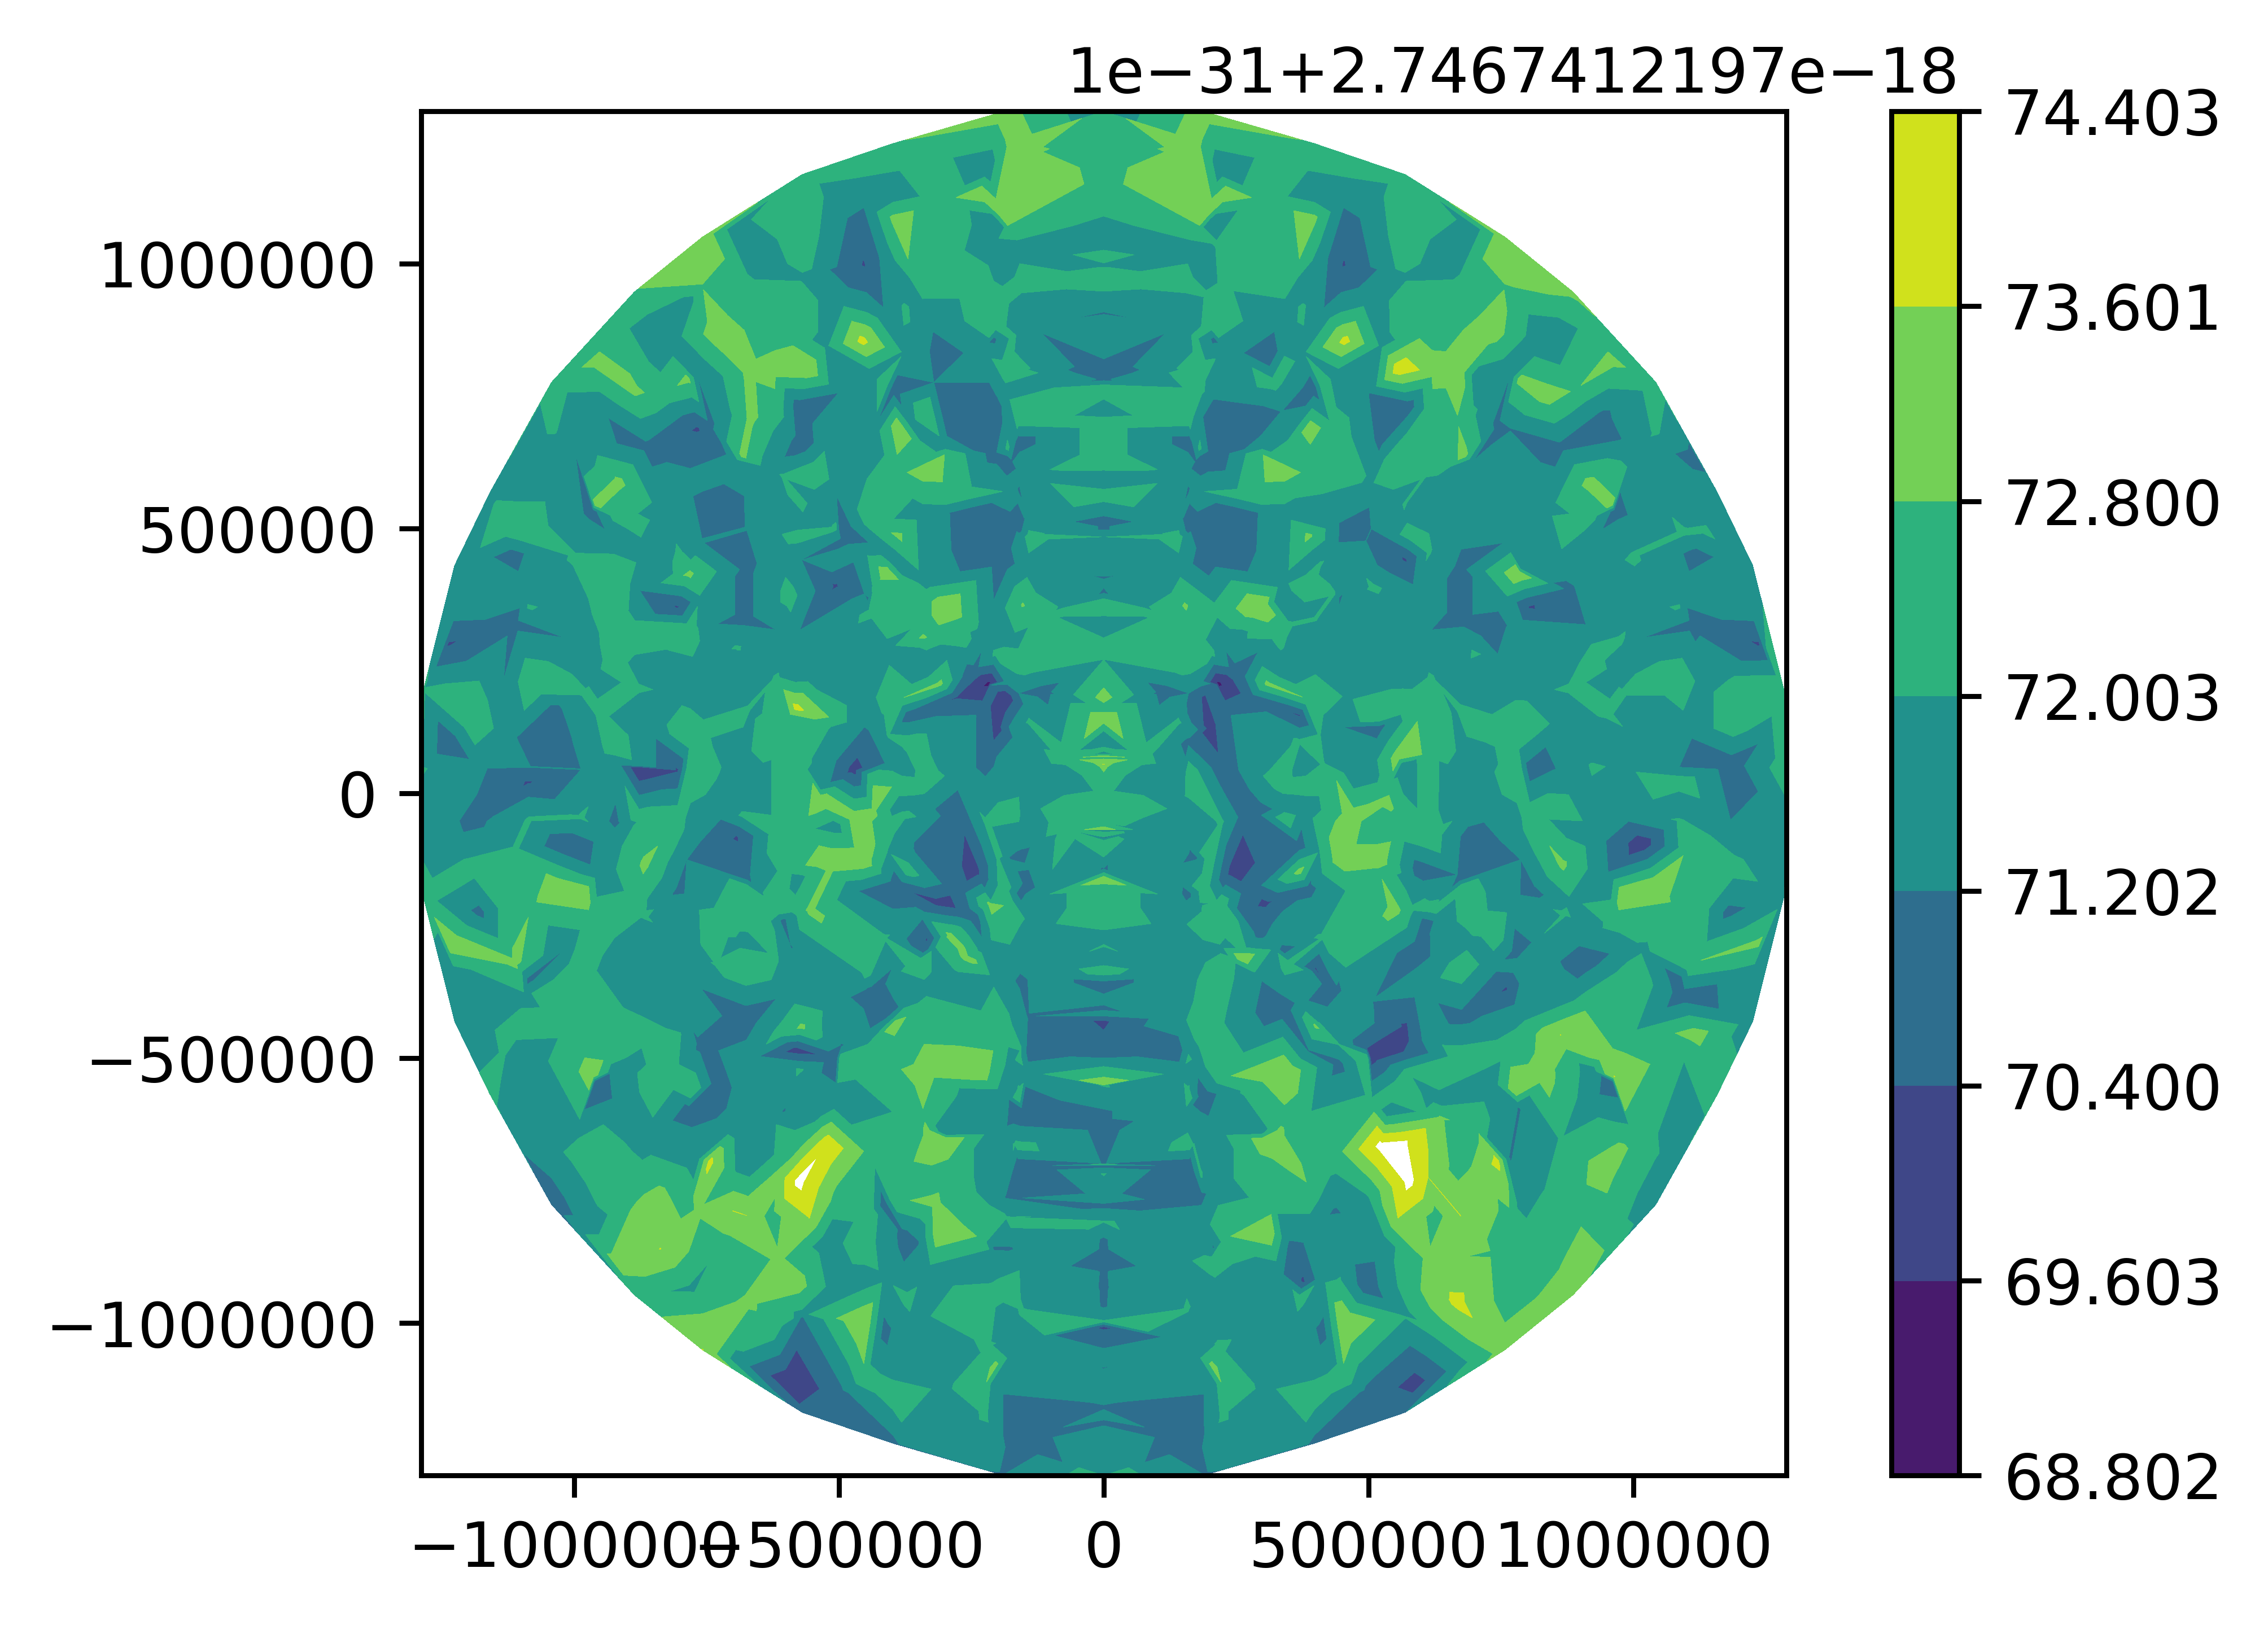

In [7]:
# Image

import matplotlib.pyplot as plt
%matplotlib inline

data = np.loadtxt(lastOutput + 'image_p_0.txt')

ncells_eff = model3D.ncells - len(model3D.boundary)

f = 20

imdata = data[:ncells_eff,f]

model3D.imageRay(0)
x = model3D.imageX[:ncells_eff]
y = model3D.imageY[:ncells_eff]

plt.figure(dpi=800)
#plt.plot(x, y, 'k.')
plt.tricontourf(x,y,imdata)
plt.colorbar()
plt.axes().set_aspect('equal')

### 2.2) Map sphere to 1D model

In [8]:
# Map to 1D model

pops_data = deSphere(cellsInShell, pops_3D_data)
pops_var  = sphereVar(cellsInShell, pops_3D_data)

J_data = deSphere(cellsInShell, J_3D_data)
J_var  = sphereVar(cellsInShell, J_3D_data)

G_data = deSphere(cellsInShell, G_3D_data)
G_var   = sphereVar(cellsInShell, G_3D_data)

Jeff_data = deSphere(cellsInShell, Jeff_3D_data)
Jeff_var  = sphereVar(cellsInShell, Jeff_3D_data)

nu_data = deSphere(cellsInShell, nu_3D_data)
nu_var  = sphereVar(cellsInShell, nu_3D_data)

lnr_data = deSphere(cellsInShell, lnr_3D_data)
lnr_var  = sphereVar(cellsInShell, lnr_3D_data)

#freqsR   = deSphere(cellsInShell, [freqs])
#freqsVar = sphereVar(cellsInShell, [freqs])

#etaR   = deSphere(cellsInShell, eta_data)
#etaVar = sphereVar(cellsInShell, eta_data)

#chiR   = deSphere(cellsInShell, chi_data)
#chiVar = sphereVar(cellsInShell, chi_data)

for s in range(model.ncells):
    #print(f'pops_var  = {np.max(pops_var[0][s])}')
    #print(f'Jeff_var  = {np.max(Jeff_var[0][s])}')
    print(f'   J_var     = {np.max(J_var[0][s])}')
    print(f'   G_var     = {np.max(G_var[0][s])}')
    #print(f'nu_var    = {np.max(nu_var[0][s])}')
    #print(f'lnr_var   = {np.max(lnr_var[0][s])}')

#print(np.max(etaVar))
#print(np.max(chiVar))

   J_var     = 0.0
   G_var     = 0.0
   J_var     = 2.4008264625568603e-16
   G_var     = 124.398363929437
   J_var     = 2.489745961170078e-16
   G_var     = 7018.727557072639
   J_var     = 2.759460937069386e-16
   G_var     = 4544.977809319695
   J_var     = 6.604193012343149e-16
   G_var     = 1979.9034779051829
   J_var     = 8.097752008469417e-16
   G_var     = 355.5532906698566
   J_var     = 1.0365122570842535e-15
   G_var     = 2755.690675505215
   J_var     = 1.4703118313457236e-15
   G_var     = 1034.7095346293772
   J_var     = 1.9386618141769036e-15
   G_var     = 1434.0097162291506
   J_var     = 2.395494994151866e-15
   G_var     = 53.265230310475644
   J_var     = 2.9589185838979994e-15
   G_var     = 515.2967152772445
   J_var     = 3.5716484858739654e-15
   G_var     = 4617.955316419373
   J_var     = 4.429470348640548e-15
   G_var     = 152.3682978031948
   J_var     = 4.927752713375799e-15
   G_var     = 41.167967158762636
   J_var     = 0.018448522424479988
   G_v

### Plot 1D model output

In [9]:
# Plot functions

def color(s):
    ns = int((s_max-s_min) / s_step + 1)
    es = int((s    -s_min) / s_step)
    return cividis(ns)[es]

def legend(s):
    return f'{s}'

def bokeh_log_plot(title, x, y, xlabel, ylabel):
    return

In [10]:
s_min  = 0
s_max  = model.ncells-1
s_step = 1

In [11]:
# Level populations

plot = figure (title='Level populations', width=700, height=400, y_axis_type='log')
for s in range(s_min, s_max, s_step):
    x = range(lineData.nlev)
    y = pops_data[0][s]
    plot.line (x, y, color=color(s), legend=legend(s))
plot.xaxis.axis_label = "number of the level"
plot.yaxis.axis_label = "population [m^-3]"
show (plot)

In [12]:
# Mean intensity

plot = figure (title='Total mean intensity', width=700, height=400, y_axis_type='log')
for s in range(s_min, s_max, s_step):
    x = range(lineData.nrad)
    y = Jeff_data[1][s]
    plot.line(x, y, color=color(s), legend=legend(s))
plot.xaxis.axis_label = "number of the transition"
plot.yaxis.axis_label = "mean intensity J [m^-3]"
show(plot)

In [13]:
# Spectrum

plot = figure (title='Spectrum', width=700, height=500, y_axis_type='log')
for s in range(s_min, s_max, s_step):
    x = nu_data[0][s]
    y =  J_data[0][s]
    plot.line(x, y, color=color(s), legend=legend(s))
plot.xaxis.axis_label = "frequencies [Hz]"
plot.yaxis.axis_label = "Mean intensity [W/m^2]"
show(plot)

## 3) Analytical solution

Assuming a constant source function $S_{\nu}(x)=S_{\nu}$ along the ray and boundary condition $B_{\nu}$ on both sides of the ray, the mean intensity is given by

\begin{align}
    J_{\nu}^{\text{ray}}(\tau(x)) \ = \ S_{\nu} \ + \ \frac{1}{2} \ \left(B_{\nu}-S_{\nu}\right) \ \left[e^{-\tau_{\nu}(x)} + e^{-\tau_{\nu}(L-x)}\right],
\end{align}

where the optical depth $\tau_{\nu}$ is given by

\begin{equation}
    \tau_{\nu}(\ell) \ = \ \int_{0}^{\ell} \text{d} l \ \chi_{\nu}(l) .
\end{equation}

The frequency dependence of the opacity only comes from the line profile

\begin{equation}
    \chi_{\nu}(x) \ = \ \chi_{ij} \phi_{\nu},
\end{equation}

where we assume a Gaussian profile

\begin{equation}
	\phi_{\nu}^{ij}(x) \ = \ \frac{1}{\sqrt{\pi} \ \delta\nu_{ij}} \ \exp \left[-\left(\frac{\nu-\nu_{ij}} {\delta\nu_{ij}(x)}\right)^{2}\right], \hspace{5mm} \text{where} \hspace{5mm} \delta\nu_{ij}(x) \ = \ \frac{\nu_{ij}}{c} \sqrt{ \frac{2 k_{b} T(x)}{m_{\text{spec}}} \ + \ v_{\text{turb}}^{2}(x)}.
\end{equation}

In a sphere of radius $R$, on a dinstence $r$ from the center, the distance $z$ to the boundary in a direction under an angle $\theta$ with the position vector $\textbf{r}$ is

\begin{equation}
z(r,\theta) \ = \ \sqrt{R^{2} + r^{2} \left(1 + \sin^{2} \theta\right)} - r \sin \theta .
\end{equation}
so the optical depth along such a ray is

\begin{equation}
    \tau_{\nu}(r,\theta) \ = \ \chi_{\nu}(l) z(r,\theta)
\end{equation}

and hence the mean intensity is

\begin{align}
    J_{\nu}(r) \ = \ S_{\nu} \ + \ \left(B_{\nu}-S_{\nu}\right) \ \int_{0}^{\pi} \frac{\text{d} \theta}{\pi} \ e^{-\tau_{\nu}(r,\theta)},
\end{align}

In [14]:
# Set line
line = 15

In [15]:
# Analytical model

import scipy.integrate as integrate

c     = 2.99792458E+8    # [m/s] speed of light
kb    = 1.38064852E-23   # [J/K] Boltzmann's constant
mp    = 1.6726219E-27    # [kg]  proton mass
T_CMB = 2.7254800        # [K]   CMB temperature
vturb = 0.12012E3        # [m/s] turbulent speed

inverse_sqrt_pi = 0.5641895835478

pops       = lineData.LTEpop(temp) * abun
emissivity = lineData.lineEmissivity(pops)
opacity    = lineData.lineOpacity(pops)
source     = emissivity / opacity

def bcd (nu):
    return planck(T_CMB, nu)

S    =  source[line]
chi  = opacity[line]
R    = model.x[-1]
vmax = model.vx[-1]
nuij = lineData.frequency[line]
dnu  = nuij/c * np.sqrt(2.0*kb*temp/mp + vturb**2)

def phi(nu):
    return inverse_sqrt_pi / dnu * np.exp(-((nu-nuij)/dnu)**2)

def z(r, theta):
    return np.sqrt(R**2 + r**2 * (1 + np.sin(theta)**2)) - r*np.sin(theta)

def J(nu, r):
    B = bcd (nu)
    return S + (B-S) / np.pi * integrate.quad (lambda theta: np.exp(-chi*phi(nu)*z(r,theta)), 0.0, np.pi)[0]

def G(nu, r):
    B = bcd (nu)
    return   - (B-S) / np.pi * integrate.quad (lambda theta: np.exp(-chi*phi(nu)*z(r,theta)), 0.0, np.pi)[0]

def relativeError(a,b):
    return 2.0 * np.abs((a-b)/(a+b))

In [16]:
# Line

plot_model = figure(title='Line model', width=400, height=400, y_axis_type="log")
for s in range(s_min, s_max, s_step):
    M = int(lnr_data[0][s][line] - 18    )
    N = int(lnr_data[0][s][line] + 18 + 1)
    # model
    x = nuij + 18 * dnu * np.linspace(-1,1,500)
    y = [J(xi, model.x[s]) for xi in x]
    plot_model.line(x, y, color=color(s))
    # data
    x = nu_data[0][s][M:N]
    y =  J_data[0][s][M:N]
    plot_model.circle(x, y, color=color(s), legend=legend(s))

plot_error = figure(title='Line error', width=400, height=400, y_axis_type="log")
for s in range(s_min, s_max, s_step):
    M = int(lnr_data[0][s][line] - 18    )
    N = int(lnr_data[0][s][line] + 18 + 1)
    # error
    x  = nu_data[0][s][M:N]
    JJ = [J(xi, model.x[s]) for xi in x]
    y = relativeError(JJ, J_data[0][s][M:N])
    plot_error.circle(x, y, color=color(s), legend=legend(s))

plot = gridplot([[plot_model, plot_error]])

show(plot)

In [17]:
plot_model = figure(title='Line model', width=400, height=400, y_axis_type="log")
for s in range(s_min, s_max, s_step):
    M = int(lnr_data[0][s][line] - 18    )
    N = int(lnr_data[0][s][line] + 18 + 1)
    # model
    x = nuij + 18 * dnu * np.linspace(-1,1,500)
    y = [G(xi, model.x[s]) for xi in x]
    plot_model.line(x, y, color=color(s))
    # data
    x = nu_data[0][s][M:N]
    y =  G_data[0][s][M:N]
    plot_model.circle(x, y, color=color(s), legend=legend(s))

plot_error = figure(title='Line error', width=400, height=400, y_axis_type="log")
for s in range(s_min, s_max, s_step):
    M = int(lnr_data[0][s][line] - 18    )
    N = int(lnr_data[0][s][line] + 18 + 1)
    # error
    x  = nu_data[0][s][M:N]
    GG = [G(xi, model.x[s]) for xi in x]
    y = relativeError(GG, G_data[0][s][M:N])
    plot_error.circle(x, y, color=color(s), legend=legend(s))

plot = gridplot([[plot_model, plot_error]])

show(plot)

In [26]:
plot_line_model = figure(title='Line model', width=450, height=400, y_axis_type="log")
#for s in range(s_min, s_max, 2):
# model
xx = np.array(model.x)
plot_line_model.line(xx, J(nuij,xx))
# data
M = int(lnr_data[0][0][line])
plot_line_model.circle(xx, Jeff_data[0][:,line])

plot_line = gridplot([[plot_line_model, plot_line_error]])

show (plot_line)

In [7]:
for a in range(-4):
    print(a)